# Prepare and Analyze Time Series - Milestone 1

This Jupyter notebook serves as a guided workflow to Milestone 1 of the liveProject on End-to-end Time Series Forecasting with Deep Learning.

You can upload this notebook to Colab and work from there. Alternatively, you can also work on this notebook in your local environment.

Our aim in this Milestone is to perform preliminary data processing and cleaning to have preprocessed data ready, as shown by the red dotted box in the diagram below.

![Milestone 1](https://s3.ap-southeast-1.amazonaws.com/www.jiahao.io/manning/project1_milestone_1.png)

## Importing Necessary Libraries and Functions

Let us first import the necessary libraries and load the data that we will be working with throughout this Milestone.  

The data (data/sales.csv) that we are using is a daily retail sales dataset modified from the [M5 competition data](https://www.kaggle.com/c/m5-forecasting-accuracy/data). 

In this liveProject, you are a data scientist at a large retailer and your challenge is to forecast the sales of the respective stores by each category for the next 28 days.

<ins>Instructions</ins>:<br>
- We have written the code to import the libraries so you can just run it as-is. If you need other libraries while working on this notebook, please feel free to add the library to this cell below.

In [1]:
RunningInCOLAB = 'google.colab' in str(get_ipython())

# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

%matplotlib inline

# suppress pandas SettingWithCopyWarning 
pd.options.mode.chained_assignment = None

## Previewing the Sales Data

Let us first have a preview of the data to understand what we will be working with.

<ins>Instructions</ins>:<br>
- Read in the data *sales.csv* from the data folder into a pandas dataframe and preview the first 5 rows.

<ins>Note</ins>:<br>
- If you are running this notebook in Colab, please upload *sales.csv* from the data folder.

<ins>Hints</ins> (click when needed):<br>
- [Follow the example code here to upload files to Colab from your local file system](https://colab.research.google.com/notebooks/io.ipynb)
- [Use Pandas `read_csv` function to load CSV data](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)
- [Use Pandas `head` method to preview first 5 rows of dataframe `df`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html) 

In [2]:
# upload file from Colab
sales_df = pd.read_csv('sales.csv')

In [3]:
# load data and view first 5 rows
sales_df.head()

,date,store_id,cat_id,sales
0,2011-01-29,TX_1,FOODS,3950.35
1,2011-01-30,TX_1,FOODS,3844.97
2,2011-01-31,TX_1,FOODS,2888.03
3,2011-02-01,TX_1,FOODS,3631.28
4,2011-02-02,TX_1,FOODS,3072.18


You should see from the data preview that there are 4 columns with ~58k rows. The daily sales (column: `sales`) for each store (column: `store_id`) and category (column: `cat_id`) are listed in each row. 

If we generate the unique value count of the `store_id` and `cat_id`, we will see that there are 10 stores and 3 categories. Each store and category group is a time series, so we have 30 time series.

<ins>Instruction</ins>:<br>
- Verify the number of unique values of `store_id` and `cat_id` each.

<ins>Hints</ins>:<br>
- [Pandas `nunique` method can be used to verify number of unique values](https://pandas.pydata.org/docs/reference/api/pandas.Series.nunique.html)

In [4]:
# unique count of store_id and cat_id
print(f"Total unique stores in sales_df are: {sales_df['store_id'].nunique()}")
print(f"Total unique categories in sales_df are: {sales_df['cat_id'].nunique()}")

Total unique stores in sales_df are: 10
Total unique categories in sales_df are: 3


And in terms of the time period, our sales data start from 2011 to 2016. We also set the `date` column to datetime format.

<ins>Instructions</ins>:<br>
- Verify the date range of the `sales` data

<ins>Hints</ins> (click when needed):<br>
- [Use Pandas `to_datetime` function to convert dates in string format to datetime format](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html)

In [5]:
sales_df['date'].dtype

dtype('O')

In [6]:
# verify max and min date
sales_df['date'] = pd.to_datetime(sales_df['date'])
print(sales_df['date'].max())
print(sales_df['date'].min())

2016-05-22 00:00:00
2011-01-29 00:00:00


## Processing of Data

There are 3 common data quality issues to check for time series data:
1. Irregular time series
2. Outliers
3. Missing data

### Data quality issue - Irregular time series

In our case, our sales data is of daily frequency. However, the data may possibly miss out some dates (see point 1 in image below) or added more rows for the same date (see point 2 in image below). Hence, we need to ensure that every date is accounted by exactly one row. 

For the scenario of point 2 in image below, we will also need to check with the data owner on the proper treatment, i.e., do we add up the sales of both rows to get sales for 2011-02-19 or do we just keep the row with time 00:00:00 because the data is a snapshot of sales? 



![Irregular Time Series](https://s3.ap-southeast-1.amazonaws.com/www.jiahao.io/manning/irregular_time_period.PNG)

<ins>Instruction</ins>:<br>
- Check for duplicated dates within a store and category group

<ins>Hints</ins> (click when needed):<br>
- [Use Pandas `duplicated` method to check for duplicates](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html)

In [7]:
sales_df.shape[0]

58230

In [8]:
# check for duplicate dates within a store and category group
sales_df.duplicated(subset=['date', 'store_id', 'cat_id']).sum()

0

You should find that there is no duplicated date in a store and category group.

Next let's try to see if there is missing date in between the start and end date of sales.

<ins>Instructions</ins>:<br>
- Generate dataframe with the daily dates in between the start and end dates of sales. Then check if there is any missing date(s) in between.

<ins>Hints</ins> (click when needed):<br>
- [Use Pandas `date_range` function to generate dates in a specified time period](https://pandas.pydata.org/docs/reference/api/pandas.date_range.html)

In [9]:
assert(sales_df['date'].nunique() == len(pd.date_range(start = sales_df['date'].min(), end = sales_df['date'].max(), freq = 'D')))

In [10]:
# generate daily dates between the start and end of sales
# merge the dates dataframe with sales dataframe to check for missing dates
daily_dates_df = pd.DataFrame(pd.date_range(start = sales_df['date'].min(), end = sales_df['date'].max(), freq = 'D'), columns = ['date_ref'])
test_missing_dates_df = pd.merge(daily_dates_df, sales_df, left_on = "date_ref", right_on = "date", how = "left", indicator = True)
assert(test_missing_dates_df['_merge'].unique()[0] == "both") # if the only single value is 'both' it indicates that there are no missing dates

Luckily for us, there is no missing date in between. If there is any, the `sales` value will be null and we can impute them later.

### Data quality issue - Outliers

There are various ways to check for outliers in time series. Here, we use the Interquartile Range (IQR) method mentioned in the book [Forecasting: Principles and Practice](https://otexts.com/fpp3/missing-outliers.html) by Rob J Hyndman and George Athanasopoulos. However, we modified the method a little by detrending the time series first before applying the IQR method.

<ins>Instructions</ins>:<br>
- Code the IQR method and implement it on the sales data. Take care to check for outliers by each store and category group. The sales dataframe should have a column named `anomaly` that will indicate each outlier as True and non-outliers as False.
- Detrend the sales by each time series (i.e., each store and category group) before applying the IQR method.

<ins>Hints</ins> (click when needed):<br>
- [Use Pandas `quantile` method to get the quantiles values](https://pandas.pydata.org/docs/reference/api/pandas.Series.quantile.html)
- [Scipy `detrend` can be used to detrend the time series before applying IQR method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html)

In [ ]:
# 1. detrend then 2. outlier_detection

In [11]:
# first group by store_id and cat_id then apply signal.detrend on each group
g = sales_df.groupby(['store_id', 'cat_id']) # correct & reuse
sales_df['sales'] = g['sales'].transform(signal.detrend) # correct & reuse

In [12]:
# outlier detection function
def outlier_detection(df):
    """
    Add column 'anomaly' to dataframe to mark outliers as True, non-outliers as False. 
    """
    df["anomaly"] = True
    g = df.groupby(['store_id', 'cat_id'])
    for grp in list(g.groups.keys()):
        q_25 = g.get_group(grp)['sales'].quantile(0.25)
        q_75 = g.get_group(grp)['sales'].quantile(0.75)
        iqr = q_75 - q_25
        ll = q_25 - 1.5*iqr
        ul = q_75 + 1.5*iqr
        #g.get_group(grp)["anomaly"] = np.where((g.get_group(grp)['sales'] < ll) | (g.get_group(grp)['sales'] > ul), True, False).tolist() - does not work?
        df.loc[g.groups[grp], "anomaly"] = np.where((g.get_group(grp)['sales'] < ll) | (g.get_group(grp)['sales'] > ul), True, False)

    return df

# execute outlier detection function for each time series
sales_df2 = outlier_detection(sales_df)

In [13]:
sales_df2.groupby(["store_id", "cat_id"])["anomaly"].value_counts().head(10)

store_id  cat_id     anomaly
CA_1      FOODS      False      1930
                     True         11
          HOBBIES    False      1909
                     True         32
          HOUSEHOLD  False      1924
                     True         17
CA_2      FOODS      False      1867
                     True         74
          HOBBIES    False      1898
                     True         43
Name: anomaly, dtype: int64

Let's take a look at how our outlier detection method performs.

In general, the method is able to capture most of the outliers (as seen from the diagrams below) that our human judgement would also determine to be outlying points. There are some outlying points that were missed out but we shall see in a while what these points may be and we can manually mark them as outlier if necessary.

We also noticed that some of the points towards the tail end of the time series for the store *CA_2* and category *FOODS* seem to be wrongly marked as outliers. We can unmark these points as well.

<ins>Instructions</ins>:<br>
- Visualize the outliers identified by overlaying them on a sales line plot. An example plot is as shown below.

![Sales Line Plot with Outliers Example](https://s3.ap-southeast-1.amazonaws.com/www.jiahao.io/manning/sales_line_plot_w_outliers.png)


<ins>Hints</ins> (click when needed):<br>
- [Use Matplotlib `plot` function to draw a line plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html)

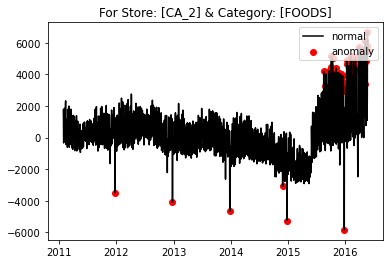

<Figure size 1440x720 with 0 Axes>

In [14]:
# sample one of the store category to see how our outlier detection performs
def visualize_outliers(store, category):
    # visualization of outliers detected
    test_df = sales_df2.loc[(sales_df2["store_id"] == store) & (sales_df2["cat_id"] == category), ["date", "sales", "anomaly"]]
    test_df_mark = test_df.loc[test_df["anomaly"] == True]
    plt.scatter(test_df_mark['date'], test_df_mark['sales'], color='red', label = 'anomaly')
    plt.plot(test_df['date'], test_df['sales'], color= "black", label = 'normal')
    plt.legend(loc = "upper right")
    plt.title(f"For Store: [{store}] & Category: [{category}]")
    plt.show()
    plt.figure(figsize=(20,10))

# sample one of the store category to see how our outlier detection performs
visualize_outliers('CA_2', 'FOODS')

We can unmark some of the points as outliers.

<ins>Instructions</ins>:<br>
- If any of the "outliers" identified are incorrect, unmark them in your `anomaly` column.

In [15]:
# unmark points as outliers
sales_df2['anomaly'] = np.where((sales_df2["store_id"]=="CA_2") & 
                                (sales_df2["cat_id"] == "FOODS") & 
                                (sales_df2["date"]>"2015-07-01"), False, sales_df['anomaly'])
#df['mark'] = df.apply(lambda x: False if x.y==3 else x.mark, 1)

It turns out that when we filter and zoom into those outlying points with sales very close to 0, they seem to generally occur on 25th Dec. Seems likely due to Christmas... Turns out when you spoke to the data owner, it was revealed that the stores close on Christmas hence the close to zero sales.

Let's mark these as outliers for the time being although we will need to take care to set predicted sales on Christmas to zero later.

<ins>Instructions</ins>:<br>
- Mark any additional points as outliers if necessary in your `anomaly` column

In [16]:
# mark points as outliers
sales_df2['anomaly'] = np.where((sales_df2["date"].dt.month == 12) & 
                                (sales_df2["date"].dt.day == 25), True, sales_df2['anomaly'])

Finally, we will need to set our outliers to null sales value. In reality, we should talk to the data owner to find out the reasons for these outliers and decide if they are legitimate data points (e.g. the Christmas points) or erroneous points.

For the Christmas data points, they reflect the calendar effect and in some models, we can leave these data points as they are and add in covariates indicating these calendar effects into the model. However for us, we will be using univariate model and it would better for us to remove these calendar effects.

Before we set the outliers to null sales value, we can check for other null sales values if any and perform imputation in our next data quality check.

### Data quality issue - Missing data

First let's check for missing sales value. Then we proceed to set outlier to null sales value as mentioned in previous data quality check. And finally perform imputation of sales.

<ins>Instructions</ins>:<br>
- Check how many rows have missing sales value

<ins>Hints</ins> (click when needed):<br>
- [Use Pandas `isna` method to check number of missing rows](https://pandas.pydata.org/docs/reference/api/pandas.Series.isna.html)

In [17]:
# check number of rows with missing sales
sales_df2.loc[sales_df2['sales'].isna(),:].shape[0]

0

Good, seems like no missing sales. Well in fact, we knew there's no missing sales when we were previewing the data. But this is just for procedure.

Next we can set our outliers to null sales value.

<ins>Instructions</ins>:<br>
- Set outliers to null sales value

In [18]:
# set outlier to null sales value
sales_df2.loc[sales_df2['anomaly']==True, 'sales'] = np.nan

We can now proceed to impute the missing sales. In our case, we have no extended missing sales period and the number of data points with missing sales is little compared to the total number of data points. Hence, we shall adopt linear interpolation method.

First, we need to set the `date`, `store_id` and `cat_id` columns as index.

<ins>Instructions</ins>:<br>
- Impute the missing sales using linear interpolation method.

<ins>Hints</ins> (click when needed):<br>
- [Use Pandas `interpolate` method to impute using linear interpolation method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html)

In [ ]:
sales_df2.columns

In [19]:
# impute missing sales
sales_df2 = sales_df2.drop(columns = ['anomaly'])
sales_df2.set_index(['date', 'store_id', 'cat_id'], inplace = True)
sales_df2['sales'] = sales_df2['sales'].interpolate()
sales_df2.head(20)

,,,sales
date,store_id,cat_id,
2011-01-29,TX_1,FOODS,-160.500963
2011-01-30,TX_1,FOODS,-266.532119
2011-01-31,TX_1,FOODS,-1224.123274
2011-02-01,TX_1,FOODS,-481.524430
2011-02-02,TX_1,FOODS,-1041.275586
2011-02-03,TX_1,FOODS,713.563258
2011-02-04,TX_1,FOODS,-1249.097898
2011-02-05,TX_1,FOODS,330.680946
2011-02-06,TX_1,FOODS,875.699791


With these data quality checks done, we have completed Milestone 1 and prepared our preprocessed data. Good job!

Now let's save our preprocessed data as `sales_processed.csv` in the data folder.

<ins>Instructions</ins>:<br>
- Save the preprocessed data as `sales_processed.csv` in the data folder

<ins>Hints</ins> (click when needed):<br>
- [Use Pandas `to_csv` method to save your output as CSV file](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html)

In [20]:
# write to CSV
sales_df2.reset_index(drop = False).to_csv('sales_processed.csv', index = False)

Do check your answers against our solution before moving on to the next Milestone.